# Exercise : Convolution Neural Network

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import os
import random

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
# Download data and define the transformer (data normalization)
# Do not change this function
def load_data(seed_value=42):
  MNIST_normalize = transforms.Normalize((0.1307,), (0.3081,))
  MNIST_transform = transforms.Compose([
      transforms.ToTensor(),
      MNIST_normalize
  ])

  # MNIST Dataset
  train = datasets.MNIST(root='./data/',
                                train=True,
                                transform=MNIST_transform,
                                download=True)

  test = datasets.MNIST(root='./data/',
                                train=False,
                                transform=MNIST_transform)

  #print(valid.dataset.data.shape)
  train_subset_size = 5000
  train.data = train.data[0:train_subset_size]
  train.targets = train.targets[0:train_subset_size]

  train_size = int(0.9 * train_subset_size)
  val_size =  int(0.1 * train_subset_size)
  print("train_set_size:", train_size)
  print("val_set_size:", val_size)

  train, valid = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(seed_value))

  return train, valid, test

In [4]:
# function to show data
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
# Data Loader 
def get_data_loaders(dataset, batch_size, shuffle=True):
  loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=batch_size,
                                            shuffle=shuffle)
  return loader

In [6]:
# Model
class Conv_Net(nn.Module):
    def __init__(self, dropout_value=0.5):
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3)
        self.mp = nn.MaxPool2d(2)
        self.drop = nn.Dropout(dropout_value)
        self.fc = nn.Linear(6400, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.drop(x)
        x = self.fc(x)
        return F.log_softmax(x)

In [7]:
def train(epoch, train_loader, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))


In [8]:
def test(test_loader, device, is_train_set=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
          data, target = Variable(data).to(device), Variable(target).to(device)
          output = model(data)
          # sum up batch loss
          test_loss += F.nll_loss(output, target, size_average=False).data
          # get the index of the max log-probability
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\n{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        'Train evaluation' if is_train_set else 'Val/Test evaluation', test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Model for answering questions A & B

In [9]:
seed_everything(seed=42)
# Training settings
batch_size = 128
lr = 0.1
momentum = 0.9 
l2 = 0.0
dropout_value = 0.0
num_epochs = 15
device = 'cpu'

# define the network
model = Conv_Net(dropout_value).to(device)

# define the optimizer 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= l2)

train_dataset, val_dataset, test_dataset = load_data()

#divide data to train and val
train_loader = get_data_loaders(train_dataset, batch_size, shuffle=True)
val_loader = get_data_loaders(val_dataset, batch_size, shuffle=False)
test_loader = get_data_loaders(test_dataset, batch_size, shuffle=False)


for epoch in range(1, num_epochs):
    train(epoch, train_loader, device)
    test(train_loader, device, is_train_set=True)
    test(val_loader, device, is_train_set=False)


test(test_loader, device, is_train_set=False)

train_set_size: 4500
val_set_size: 500


<ipython-input-6-5823d334e1cc>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/4500 (0%)]	Loss: 2.289669
Train Epoch: 1 [1280/4500 (28%)]	Loss: 0.649360
Train Epoch: 1 [2560/4500 (56%)]	Loss: 0.240182
Train Epoch: 1 [3840/4500 (83%)]	Loss: 0.378277


/home/bas/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Train evaluation: Average loss: 0.1670, Accuracy: 4280/4500 (95%)


Val/Test evaluation: Average loss: 0.1903, Accuracy: 473/500 (95%)

Train Epoch: 2 [0/4500 (0%)]	Loss: 0.158392
Train Epoch: 2 [1280/4500 (28%)]	Loss: 0.346545
Train Epoch: 2 [2560/4500 (56%)]	Loss: 0.199414
Train Epoch: 2 [3840/4500 (83%)]	Loss: 0.064264

Train evaluation: Average loss: 0.0885, Accuracy: 4380/4500 (97%)


Val/Test evaluation: Average loss: 0.1062, Accuracy: 482/500 (96%)

Train Epoch: 3 [0/4500 (0%)]	Loss: 0.098561
Train Epoch: 3 [1280/4500 (28%)]	Loss: 0.036250
Train Epoch: 3 [2560/4500 (56%)]	Loss: 0.119853
Train Epoch: 3 [3840/4500 (83%)]	Loss: 0.126679

Train evaluation: Average loss: 0.0748, Accuracy: 4391/4500 (98%)


Val/Test evaluation: Average loss: 0.1069, Accuracy: 483/500 (97%)

Train Epoch: 4 [0/4500 (0%)]	Loss: 0.053599
Train Epoch: 4 [1280/4500 (28%)]	Loss: 0.114285
Train Epoch: 4 [2560/4500 (56%)]	Loss: 0.025519
Train Epoch: 4 [3840/4500 (83%)]	Loss: 0.020782

Train evaluation: Averag

# Model for answering option C

In [10]:
seed_everything(seed=42)
# Training settings
batch_size = 128
lr = 0.1
momentum = 0.9
l2 = 0.0
dropout_value = 0.5
num_epochs = 15
device = 'cpu'

# define the network
model = Conv_Net(dropout_value).to(device)

# define the optimizer 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= l2)

train_dataset, val_dataset, test_dataset = load_data()

#divide data to train and val
train_loader = get_data_loaders(train_dataset, batch_size, shuffle=True)
val_loader = get_data_loaders(val_dataset, batch_size, shuffle=False)
test_loader = get_data_loaders(test_dataset, batch_size, shuffle=False)


for epoch in range(1, num_epochs):
    train(epoch, train_loader, device)
    test(train_loader, device, is_train_set=True)
    test(val_loader, device, is_train_set=False)


test(test_loader, device, is_train_set=False)

train_set_size: 4500
val_set_size: 500


<ipython-input-6-5823d334e1cc>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/4500 (0%)]	Loss: 2.298145
Train Epoch: 1 [1280/4500 (28%)]	Loss: 0.803176
Train Epoch: 1 [2560/4500 (56%)]	Loss: 0.302769
Train Epoch: 1 [3840/4500 (83%)]	Loss: 0.403279

Train evaluation: Average loss: 0.1545, Accuracy: 4281/4500 (95%)


Val/Test evaluation: Average loss: 0.1650, Accuracy: 470/500 (94%)

Train Epoch: 2 [0/4500 (0%)]	Loss: 0.168231
Train Epoch: 2 [1280/4500 (28%)]	Loss: 0.318939
Train Epoch: 2 [2560/4500 (56%)]	Loss: 0.316243
Train Epoch: 2 [3840/4500 (83%)]	Loss: 0.285534

Train evaluation: Average loss: 0.1026, Accuracy: 4354/4500 (97%)


Val/Test evaluation: Average loss: 0.1430, Accuracy: 479/500 (96%)

Train Epoch: 3 [0/4500 (0%)]	Loss: 0.133969
Train Epoch: 3 [1280/4500 (28%)]	Loss: 0.162919
Train Epoch: 3 [2560/4500 (56%)]	Loss: 0.177316
Train Epoch: 3 [3840/4500 (83%)]	Loss: 0.186778

Train evaluation: Average loss: 0.0753, Accuracy: 4392/4500 (98%)


Val/Test evaluation: Average loss: 0.1338, Accuracy: 478/500 (96%)

Train Epoch: 4 [0/4500 (0

# Model for answering option D

In [11]:
seed_everything(seed=42)
# Training settings
batch_size = 128
lr = 0.1
momentum = 0.9 
l2 = 0.05
dropout_value = 0.0
num_epochs = 15
device = 'cpu'

# define the network
model = Conv_Net(dropout_value).to(device)

# define the optimizer 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= l2)

train_dataset, val_dataset, test_dataset = load_data()

#divide data to train and val
train_loader = get_data_loaders(train_dataset, batch_size, shuffle=True)
val_loader = get_data_loaders(val_dataset, batch_size, shuffle=False)
test_loader = get_data_loaders(test_dataset, batch_size, shuffle=False)


for epoch in range(1, num_epochs):
    train(epoch, train_loader, device)
    test(train_loader, device, is_train_set=True)
    test(val_loader, device, is_train_set=False)


test(test_loader, device, is_train_set=False)

train_set_size: 4500
val_set_size: 500


<ipython-input-6-5823d334e1cc>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/4500 (0%)]	Loss: 2.289669
Train Epoch: 1 [1280/4500 (28%)]	Loss: 0.427784
Train Epoch: 1 [2560/4500 (56%)]	Loss: 0.211098
Train Epoch: 1 [3840/4500 (83%)]	Loss: 0.308220

Train evaluation: Average loss: 0.2437, Accuracy: 4151/4500 (92%)


Val/Test evaluation: Average loss: 0.2647, Accuracy: 462/500 (92%)

Train Epoch: 2 [0/4500 (0%)]	Loss: 0.184595
Train Epoch: 2 [1280/4500 (28%)]	Loss: 0.274580
Train Epoch: 2 [2560/4500 (56%)]	Loss: 0.350785
Train Epoch: 2 [3840/4500 (83%)]	Loss: 0.289892

Train evaluation: Average loss: 0.2503, Accuracy: 4165/4500 (93%)


Val/Test evaluation: Average loss: 0.2618, Accuracy: 460/500 (92%)

Train Epoch: 3 [0/4500 (0%)]	Loss: 0.230139
Train Epoch: 3 [1280/4500 (28%)]	Loss: 0.235649
Train Epoch: 3 [2560/4500 (56%)]	Loss: 0.189001
Train Epoch: 3 [3840/4500 (83%)]	Loss: 0.276287

Train evaluation: Average loss: 0.2366, Accuracy: 4198/4500 (93%)


Val/Test evaluation: Average loss: 0.2471, Accuracy: 461/500 (92%)

Train Epoch: 4 [0/4500 (0

# Question 1 - C

<div>
    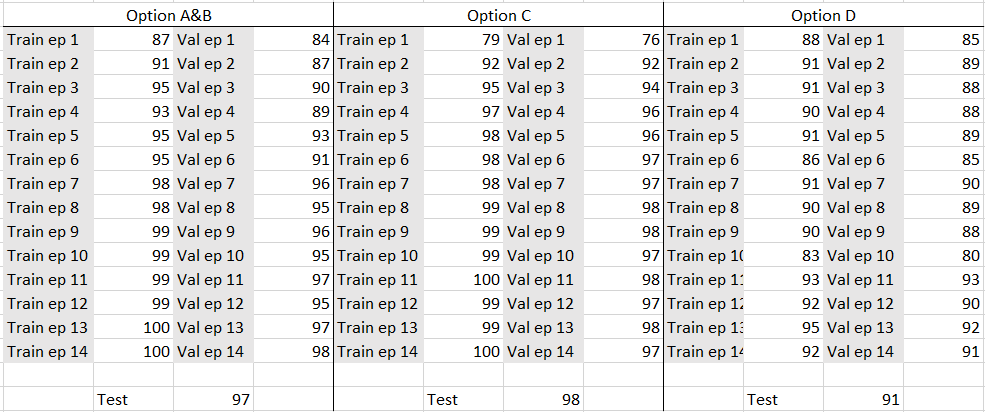
</div>

**Option A: Untrue**, the accuracy on the validation set after the last epoch is higher than on the test set.

**Option B: Untrue**, a model that achieves 100% train accuracy and >95% validation and test accuracy is not underfitting.

**Option C: True!** The validation accuracy does increase, if only slightly. Throughout training we also see that validation accu

**Option D: Untrue**, performance on all data subsets gets worse so it just makes the model as a whole worse here.

--------------------------------

In [12]:
!pip3 install JSAnimation

In [13]:
import pandas as pd # pandas is a data manipulation library
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import matplotlib.pyplot as plt # data visualization library
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from JSAnimation import IPython_display
from matplotlib import animation
from IPython.display import HTML

# Exercise : MF Faces

In [14]:
faces = fetch_olivetti_faces()
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

Definition of the data matrix:

In [15]:
D = faces.data

The observations/rows pf the data matrix can be visualized as pictures. 10 consecutive pictures are taken from one person. This are the first 30 pictutres.

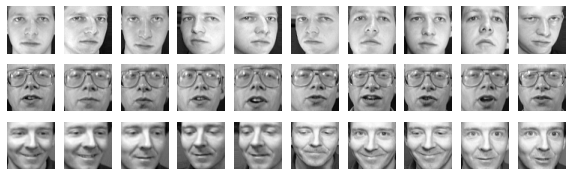

In [16]:
# Here are the first ten guys of the dataset
fig = plt.figure(figsize=(10, 3))
for i in range(30):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
    
    ax.imshow(D[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

# Exercise 2 - PCA implementation - C

In [17]:
# D = data matrix
def PCA(D,r):
    # For each row, collect the means and subtract them from their respective rows
    mu_F = D.mean(axis=1).reshape(-1, 1)
    C = D-mu_F
    # Randomized SVD functions returns a transposed V
    U, Sigma, V_T = randomized_svd(D, r)
    svd_dict = {'U': U, "Sigma": Sigma, "V_T": V_T}
    return C@V_T.T, svd_dict, mu_F

In [18]:
#D.mean(axis=1)

In [19]:
pca_25, tr_svd_25, mu_F = PCA(D,25)
pca_50, tr_svd_50, mu_F = PCA(D,50)
pca_100, tr_svd_100, mu_F = PCA(D,100)

/home/bas/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


## Option A

Option A: does this look like the image in the question pdf?
TRUE: It does indeed look exactly like it.


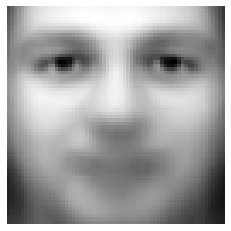

In [20]:
print("Option A: does this look like the image in the question pdf?")
average_image = mu_F.T@D
plt.imshow(average_image.reshape(64,64), cmap=plt.cm.gray)
plt.axis('off')
print("TRUE: It does indeed look exactly like it.")

## Option B

The original, just to be sure:


(-0.5, 63.5, 63.5, -0.5)

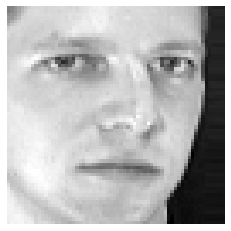

In [21]:
print('The original, just to be sure:')
plt.imshow(D[1].reshape(64,64), cmap=plt.cm.gray)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

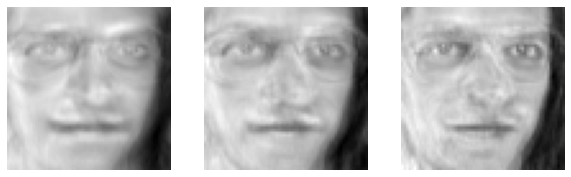

In [22]:
image_25_pca = pca_25[1]@tr_svd_25["V_T"] + mu_F[1]
image_50_pca = pca_50[1]@tr_svd_50["V_T"] + mu_F[1]
image_100_pca = pca_100[1]@tr_svd_100["V_T"] + mu_F[1]

fig = plt.figure(figsize=(10, 3))
ax = plt.subplot2grid((1,3), (0,0))
ax.imshow(image_25_pca.reshape(64,64), cmap=plt.cm.gray)
ax.axis('off')
ax = plt.subplot2grid((1,3), (0,1))
ax.imshow(image_50_pca.reshape(64,64), cmap=plt.cm.gray)
ax.axis('off')
ax = plt.subplot2grid((1,3), (0,2))
ax.imshow(image_100_pca.reshape(64,64), cmap=plt.cm.gray)
ax.axis('off')

Well, it's not an exact match... But close enough! I'll take that as a **True.**

### Option C

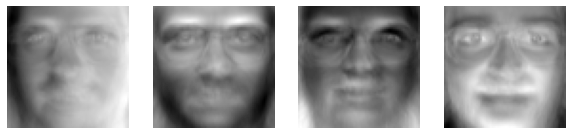

In [23]:
fig = plt.figure(figsize=(10, 3))
for i in range(4):
    ax = plt.subplot2grid((1, 4), (int(i/4), i-int(i/4)*4))
    ax.imshow(tr_svd_50["V_T"][i+1].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

The first one is rather different, and the fourth one also doesn't seem exactly the same. **Untrue.**

### Option D
Following exactly what D. says, try to recreate an image.
Try to recreate image 0:

Original image:


(-0.5, 63.5, 63.5, -0.5)

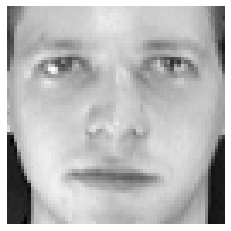

In [24]:
print("Original image:")
plt.imshow(D[0].reshape(64,64), cmap=plt.cm.gray)
plt.axis('off')

PCA with r=100 reconstruction:


(-0.5, 63.5, 63.5, -0.5)

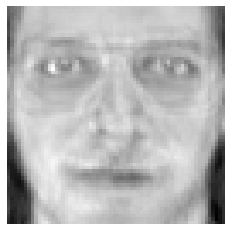

In [25]:
print("PCA with r=100 reconstruction:")
reconstruction = pca_100[0]@tr_svd_100["V_T"] + mu_F[0]
plt.imshow(reconstruction.reshape(64,64), cmap=plt.cm.gray)
plt.axis('off')

Sure seems to be working as intended, so this is **True**!

## Conclusion
Option A: **True**, exactly the same image.

Option B: **True**, more or less. It's not an exact match but it's close.

Option C: **Untrue**, two of the images do not match those showed in the question PDF.

Option D: **True**, this formula functions as intended (as one would expect).

# Exercise 3: k-means and SVD Faces - B

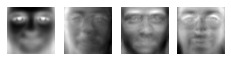

In [26]:
seed_everything(seed=42)
# Option A - correct
rank  = 4
U, s, VT = np.linalg.svd(D, full_matrices=True)
Y = U[:,0:rank]*np.sqrt([s[0:rank]])
X = VT.T[:,0:rank]*np.sqrt(s[0:rank])

# The results of option A, which are the same as the question gives. So A is True.
fig = plt.figure(figsize=(10, 3))
for i in range(4):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
    ax.imshow(X.T[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

In [27]:
# set r = 5 for option B with k means
kmeans = KMeans(n_clusters=5).fit(D)
option_B = kmeans.cluster_centers_

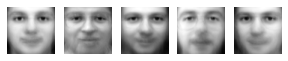

In [28]:
# the results of option B, and the five centroids of k-means r=5 is correct
fig = plt.figure(figsize=(10, 3))
for i in range(5):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
    
    ax.imshow(option_B[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

In [29]:
# reconstruct the second picture for option B, which is wrong.
sec_guy = D[1][:].reshape(-1,1)
x = [0.1, 0.2, 0.3, 2.4, -1.2]
x = np.array(x).reshape(-1,1)
y = option_B.T @ x

(-0.5, 63.5, 63.5, -0.5)

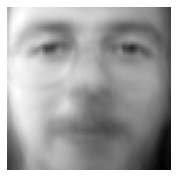

In [30]:
plt.figure(figsize=(10, 3))
plt.imshow(y.reshape(64, 64), cmap=plt.cm.gray)
plt.axis('off')

In [31]:
# option c is correct, these are not a subset.
kmeans_c = KMeans(n_clusters=3).fit(D)
kmeans_c.cluster_centers_

array([[0.48581636, 0.5385973 , 0.59522   , ..., 0.22539648, 0.22412333,
        0.22579852],
       [0.34493482, 0.35639432, 0.38451052, ..., 0.38647014, 0.39878166,
        0.39550143],
       [0.31117803, 0.3346057 , 0.36524725, ..., 0.41847596, 0.38401738,
        0.37326655]], dtype=float32)

In [32]:
kmeans.cluster_centers_

array([[0.40222844, 0.4498967 , 0.49535125, ..., 0.35219896, 0.30903187,
        0.3059327 ],
       [0.32122022, 0.3344069 , 0.35075355, ..., 0.40301412, 0.4179023 ,
        0.40866554],
       [0.446281  , 0.4796897 , 0.5261188 , ..., 0.27974427, 0.282746  ,
        0.29284266],
       [0.50549453, 0.56198347, 0.632958  , ..., 0.19271639, 0.1918082 ,
        0.187903  ],
       [0.28329325, 0.3009206 , 0.3234648 , ..., 0.43351814, 0.40898633,
        0.39392197]], dtype=float32)

In [33]:
# And option D is also correct.
svd_d1 = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
svd_d1.fit(D)
svd_d2 = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd_d2.fit(D)

TruncatedSVD(n_components=5, n_iter=7, random_state=42)

In [34]:
svd_d1.components_

array([[ 0.01119387,  0.01218334,  0.0133833 , ...,  0.00887096,
         0.00861543,  0.00853279],
       [-0.02742555, -0.03091404, -0.03455596, ...,  0.0263079 ,
         0.02292719,  0.0208091 ],
       [ 0.00035914, -0.00241208, -0.00326784, ..., -0.00912464,
        -0.00693866, -0.00549368]], dtype=float32)

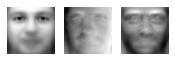

In [35]:
fig = plt.figure(figsize=(10, 3))
for i in range(3):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
    
    ax.imshow(svd_d1.components_[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

In [36]:
svd_d2.components_

array([[ 0.01119387,  0.01218334,  0.0133833 , ...,  0.00887096,
         0.00861543,  0.00853279],
       [-0.02742603, -0.03091408, -0.03455591, ...,  0.0263079 ,
         0.02292719,  0.02080911],
       [ 0.0003626 , -0.0024121 , -0.00326789, ..., -0.00912459,
        -0.00693866, -0.00549366],
       [ 0.00301318, -0.00155796, -0.01236946, ...,  0.04344533,
         0.04258889,  0.03948982],
       [-0.01614618, -0.01276133, -0.01184902, ..., -0.04578868,
        -0.04652273, -0.0463223 ]], dtype=float32)

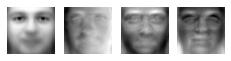

In [37]:
fig = plt.figure(figsize=(10, 3))
for i in range(4):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
    
    ax.imshow(svd_d2.components_[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

## Conclusion
Option A: **True**, we indeed get those features for $r=4$.

Option B: **Untrue**, the linear combination of these faces looks nothing like what the question says it should look like.

Option C: **True**, nothing about the centroids that are shown for $r=3$ suggests that they are a subset of those for $r=5$.

Option D: **True**, they are a subset as they should be according to the question.

# Exercise 4: k-means Initialization - D

The functions generating the datasets are given here. Every function gets as input the noise parameter ``epsilon`` and the number of points ``n`` to be sampled. It returns a tuple of the shape of clusters being generated, the dataset and the true cluster labels. 

In [38]:
def generateMoons(epsilon, n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    moons, labels = datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    scaler.fit(moons)
    return "moons", scaler.transform(moons), labels, 2
def generateBlobs(epsilon, n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    blobs, labels = datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 2.5, epsilon + 0.5], random_state=17)
    scaler.fit(blobs)
    return "blobs", scaler.transform(blobs), labels, 3
def generateCircles(epsilon, n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    circles, labels = datasets.make_circles(n_samples=n, factor=.5, noise=epsilon, random_state=27)
    scaler.fit(circles)
    return "circ", scaler.transform(circles), labels, 2
def generateAniso(epsilon,n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    A, labels = datasets.make_blobs(n_samples=n, random_state=170)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    aniso = np.dot(A, transformation)
    scaler.fit(aniso)
    return "ani", scaler.transform(aniso), labels, 3

Implement the centroid initialization here. Right now, it returns a random initialization. 

In [39]:
def calc_all_distances(row, centroids):
    """Calculate all quadratic distances"""
    distances = []
    centroid_df = pd.DataFrame(centroids)
    # Centroids are gathered column-wise, so to iterate over the centroids
    #   transpose their matrix.
    for centroid_index in centroid_df:
        centroid = np.array(centroid_df[centroid_index])
        # Quadratic distance is just Euclidean distance minus the square root
        centroid_distance = 0
        for index in range(row.shape[0]):
            component_distance = (row[index]-centroid[index])**2
            centroid_distance += component_distance
        distances.append(centroid_distance)
    return np.array(distances)

def calculate_row_probabilities(D, all_centroids):
    """
    For every row:
      Calculate distance to every centroid
      Sum them all together
      Select the smallest distance
      Store value for smallest/sum, that is P(row)
    """
    probabilities = []
    for row in D:
        distances = calc_all_distances(row, all_centroids)
        dist_sum = distances.sum()
        smallest_dist = distances.min()
        if dist_sum == 0:
            # This row is on a centroid exactly, and there is only that one
            #   centroid (this only occurs on the first iteration). Force
            #   probability to 0 to avoid div/0 issues.
            probability = 0
        else:
            probability = smallest_dist/dist_sum
        probabilities.append(probability)
    return np.array(probabilities)
    
def init_centroids_pp(D,r,random_state):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param random_state: ignored :)
        :return: (np-array) 'X' the selected centroids from the dataset
    '''
    # Sample a uniformly random row from the data
    row_ids = np.array(np.arange(D.shape[0]))
    X = D[np.random.choice(row_ids)].T
    s = 2
    while s <= r:
        # Sample i ∈ {1, . . . , n} with probability
        #   P(i) = (dist(i, X)) / (sum_{j=1}^{n} dist(j, X))
        probabilities = calculate_row_probabilities(D, X)
        # Normalize so that probabilities add up to 1
        probabilities = probabilities / probabilities.sum()
        
        weighted_sample_id = np.random.choice(a=row_ids, p=probabilities)
        chosen_row = D[weighted_sample_id].T
        
        # Attach the new centroid as a column to X
        X = np.column_stack([X, chosen_row])
        s += 1
    return X

This is the $k$-means implementation from the lecture accompanying notebook.

In [40]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)

In [41]:
def getY(labels):
    Y = np.zeros((len(labels), max(labels)+1))
    for i in range(0, len(labels)):
        Y[i, labels[i]] = 1
    return Y

def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes

def update_assignment(D,X):
    dist = np.sum(D**2,1).reshape(-1,1)  - 2* D@X + np.sum(X**2,0)
    labels = np.argmin(dist,1)
    return getY(labels)

def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

We generate a dataset.

In [42]:
n=500
dataID, D, labels, r = generateBlobs(0.05,n)
# dataID, D, labels, r = generateMoons(0.05,n)
# dataID, D, labels, r = generateAniso(0.05,n)
# dataID, D, labels, r = generateCircles(0.05,n)

Run kmeans and spectral clustering based on the initialization technique.

In [44]:
X_init = init_centroids_pp(D,r, None)
X,Y = kmeans(D, r, X_init)

5 iterations


Plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue. Note, that this kind of centroid visualization will however not work for spectral clustering.

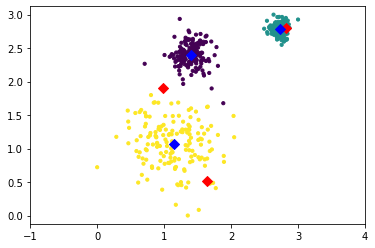

In [45]:
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
plt.xlim(-1, 4)
plt.ylim(-1, 4)
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D')
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D')

## Option A: Seems to work as intended (True)

3 iterations


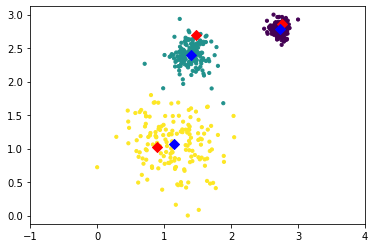

In [48]:
dataID, D, labels, r = generateBlobs(0.05,n)
X_init = init_centroids_pp(D,r, None)
X,Y = kmeans(D,r, X_init)
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
plt.xlim(-1, 4)
plt.ylim(-1, 4)
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D')
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D')

## Option B: Is indeed not functional (True)

18 iterations


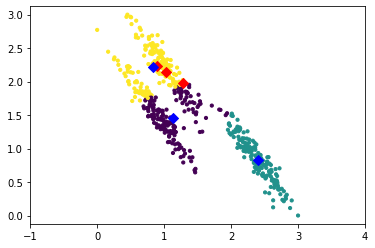

In [49]:
dataID, D, labels, r = generateAniso(0.05,n)
X_init = init_centroids_pp(D,r, None)
X,Y = kmeans(D,r, X_init)
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
plt.xlim(-1, 4)
plt.ylim(-1, 4)
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D')
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D')

## Note: Spectral clustering code is "borrowed" from lecture notebook
As described in HW3.pdf: "You can employ the implementation of spectral clustering provided in the Nonconvex Clustering lecture."

In [50]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from scipy.sparse import linalg
from itertools import cycle, islice

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                    '#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),3)))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])

def spectral_clustering(W, r):
    L = np.diag(np.array(W.sum(0))[0]) - W
    Lambda, V = linalg.eigsh(L, k=r+1, which="SM")

    kmeans = KMeans(n_clusters=r, init=init_centroids_pp)
    A = V[:,1:]
    kmeans.fit(A)
    y_pred = kmeans.labels_
    return y_pred, A

## Option C: Seems to indeed work as intended (True)

Text(0.5, 1.0, 'Spectral clustering')

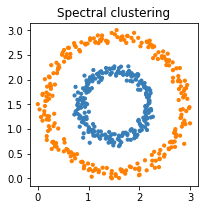

In [51]:
dataID, D, labels, r = generateCircles(0.05,n)
dataset_pd = pd.DataFrame(D)
N = kneighbors_graph(dataset_pd, n_neighbors=30,include_self=False, n_jobs=-1)
W = 0.5*(N+N.T)
y_sc_knn, A_sc_knn = spectral_clustering(W,r)

plt.figure(figsize=(3, 3))
plt.scatter(D[:, 0], D[:, 1], s=10, color=colors[y_sc_knn]) 
plt.title("Spectral clustering")

## Option D: Seems to work, while the statement says it doesn't (False)

Text(0.5, 1.0, 'Spectral clustering')

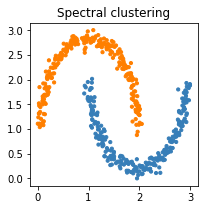

In [52]:
dataID, D, labels, r = generateMoons(0.05,n)
dataset_pd = pd.DataFrame(D)
N = kneighbors_graph(dataset_pd, n_neighbors=20,include_self=False, n_jobs=-1)
W = 0.5*(N+N.T)
y_sc_knn, A_sc_knn = spectral_clustering(W,r)

plt.figure(figsize=(3, 3))
plt.scatter(D[:, 0], D[:, 1], s=10, color=colors[y_sc_knn]) 
plt.title("Spectral clustering")

## Conclusion
Option A: **True**, seems to work as intended.

Option B: **True**, is indeed not functional.

Option C: **True**, seems to indeed work as intended.

Option D: **Untrue**, seems to work, while the statement says it doesn't.

# Exercise : Movielens
To read the dataset you might need to alter the path to look for it:

In [53]:
# lets explore movies.csv
movies= pd.read_csv('ml-latest-small/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [54]:
# lets explore ratings.CSV
ratings=pd.read_csv('ml-latest-small/ml-latest-small/ratings.csv',sep=',')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


The original ratings are in the range of 0.5 and 5:

In [55]:
min(ratings["rating"]), max(ratings["rating"])

(0.5, 5.0)

We convert the sparse representation of movie ratings into a data matrix. The missing values are filled with zeros.

In [56]:
df_movie_ratings = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)  #fill unobserved entries with μ
df_movie_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We consider here only the movies which have been rated by more than 200 users. That are 18 movies. We will not be able to infer a pattern for movies with very few observations anyways, but for this exercise we are mostly interested in the prnciple and do not need a big dataset.

In [57]:
np.sum(np.sum(df_movie_ratings!=0,0)>200)

18

In [58]:
keep_movie = np.sum(df_movie_ratings!=0,0)>200
df_D = df_movie_ratings.loc[:,keep_movie]
df_D.head()

movieId,1,47,50,110,150,260,296,318,356,480,527,589,593,780,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
5,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


Furthermore, we will throw out all the users which have not rated more than five movies.

In [59]:
np.sum(np.sum(df_D!=0,1)>5)

344

The resulting dataset has the userID as rows and movieIDs as columns. Hence, userID 1 and 4 addresses the first two rows of this dataset.

In [60]:
keep_user = np.sum(df_D!=0,1)>5
df_D = df_D.loc[keep_user,:]
df_D.head()

movieId,1,47,50,110,150,260,296,318,356,480,527,589,593,780,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
4,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
5,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,1.0,5.0,4.0,0.0,2.0,5.0,5.0,5.0,3.0,3.0,4.0,5.0,0.0,0.0,0.0,0.0
7,4.5,0.0,4.5,0.0,4.5,5.0,0.0,0.0,5.0,5.0,0.0,2.5,5.0,4.5,4.0,0.0,4.0,0.0


The movie number- title assignments are given as follows:

In [61]:
movies.loc[movies['movieId'].isin(df_D.columns)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
97,110,Braveheart (1995),Action|Drama|War
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


The resulting data matrix is given as follows:

In [62]:
D = df_D.to_numpy()
D.shape

(344, 18)

In [63]:
rng = np.random.default_rng()

def init_random(data_nr_rows, data_nr_cols, matrix_factorization_rank):
    X = rng.random((data_nr_cols, matrix_factorization_rank))
    Y = rng.random((data_nr_rows, matrix_factorization_rank))
    return X, Y

def indicator_nonzero(data, nr_data_rows, nr_data_cols):
    observed_entries = np.zeros((nr_data_rows, nr_data_cols))
    for row in range(nr_data_rows):
        for col in range(nr_data_cols):
            # I'm sure numpy has more efficient implementations of this, but if it works...
            if data[row,col] != 0:
                observed_entries[row,col] = 1
    return observed_entries

def matrix_completion(data, improvement_threshold, early_stop_limit,
                      matrix_factorization_rank = 5, t_max = 100,
                      penalty_term = 0.00001):
    """
        Reference to pseudocode:
        D = data
        r = matrix_factorization_rank
        T_{max} = t_max
        lambda = penalty_term
        n = nr_rows
        d = nr_cols
        t = t
        O = observed_entries
    """
    # These are used repeatedly, store immediately
    nr_rows = D.shape[0]
    nr_cols = D.shape[1]
    
    # Create important matrices
    X, Y = init_random(nr_rows, nr_cols, matrix_factorization_rank)
    observed_entries = indicator_nonzero(data, nr_rows, nr_cols)
    nr_observed = observed_entries.shape[0]
    
    # Store data used to monitor training (and early stopping, if c. didn't require a full run)
    mseo_list = []
    best_mseo_yet = np.inf
    no_improvement_count = 0
    
    # Additional variables that are only useful because of question c.
    mseo_early_stopping = []
    stop_triggered = False
    
    t = 1
    while t < t_max:
        for k in range(nr_cols):
            O_Xk = np.diagflat(observed_entries[:,k])
            data_col_T = data[:,k].T
            
            # Calculate the row to update in steps for readability purposes
            square_Y_matrix = Y.T@O_Xk@Y
            inverse_component = np.linalg.inv(square_Y_matrix
                                              + penalty_term*np.eye(matrix_factorization_rank))
            X[k,:] = data_col_T@Y@inverse_component
            
        for i in range(nr_rows):
            O_Yi = np.diagflat(observed_entries[i,:])
            data_row_i = data[i,:]
            
            # Calculate the row to update in steps for readability purposes
            square_X_matrix = X.T@O_Yi@X
            inverse_component = np.linalg.inv(square_X_matrix
                                              + penalty_term*np.eye(matrix_factorization_rank))
            Y[i,:] = data_row_i@X@inverse_component
        
        # Calculate the Mean Squared Error on Observed data after this epoch of training
        MSEO = 1/nr_observed * np.linalg.norm(data - observed_entries*(Y@X.T))**2
        mseo_list.append(MSEO)
        t += 1
        
        # Check if early stopping should be triggered
        if not stop_triggered and MSEO < (best_mseo_yet - improvement_threshold):
            best_mseo_yet = MSEO
            no_improvement_count = 0
        elif not stop_triggered:
            if no_improvement_count >= early_stop_limit:
                stop_triggered = True
                print(f'Early stopping would have triggered at epoch {t}. Continuing as '
                      f'question c. needs a full run.')
                mseo_early_stopping = deepcopy(mseo_list)
                # break here if you actually want early stopping
            else:
                no_improvement_count += 1
    return X, Y, mseo_list, mseo_early_stopping

In [64]:
X_0_00001, Y_0_00001, mseo_list, mseo_early_stopping = matrix_completion(D, improvement_threshold=0.0025, early_stop_limit=3)

Early stopping would have triggered at epoch 69. Continuing as question c. needs a full run.


### For question A: plot of the default settings

Text(0.5, 1.0, 'Development of Mean Square Error on Observed data')

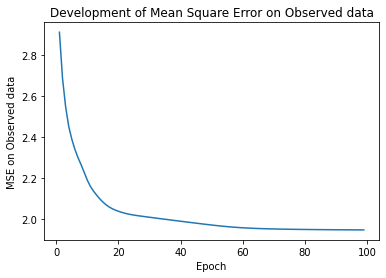

In [65]:
x_axis_labels = [i for i in range(1, len(mseo_list)+1)]
shorter_x_axis_labels = [i for i in range(1, len(mseo_early_stopping)+1)]
plt.plot(x_axis_labels, mseo_list, label="Full training")
plt.xlabel('Epoch')
plt.ylabel('MSE on Observed data')
plt.title('Development of Mean Square Error on Observed data')

### For question B:
I think so? Maybe? I really don't actually know this for sure at all, but I think so. (use slide 26 of L09 + homework pdf)

### For question C:
Stopping criterion used here:

improvement_threshold = 0.0025

Early stop is done when it takes more than 3 epochs to improve the MSEO by the amount set in _improvement_threshold_.

The resulting graph, and the difference between early stop MSEO and full run MSEO:

MSEO with early stop: 1.9525 | MSEO after full run: 1.9471



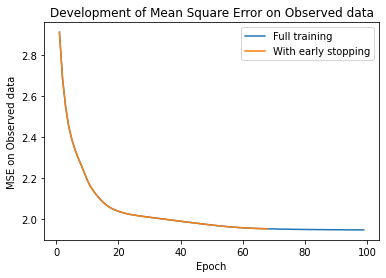

In [66]:
print(f"MSEO with early stop: {round(mseo_early_stopping[-1], 4)} | MSEO after full run: {round(mseo_list[-1], 4)}")
print()
x_axis_labels = [i for i in range(1, len(mseo_list)+1)]
shorter_x_axis_labels = [i for i in range(1, len(mseo_early_stopping)+1)]
plt.plot(x_axis_labels, mseo_list, label="Full training")
plt.plot(shorter_x_axis_labels, mseo_early_stopping, label="With early stopping")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE on Observed data')
plt.title('Development of Mean Square Error on Observed data')
plt.show()

### For question D:
State for $\lambda \in $ {1, 0.5, 0.1, 0.0001} the recommendations for the first three users.

In [67]:
X_1, Y_1, mseo_1, mseo_early_1 = matrix_completion(D, improvement_threshold=0.001, early_stop_limit=3,
                                                   penalty_term=1)
X_0_5, Y_0_5, mseo_0_5, mseo_early_0_5 = matrix_completion(D, improvement_threshold=0.001, early_stop_limit=3,
                                                           penalty_term=0.5)
X_0_1, Y_0_1, mseo_0_1, mseo_early_0_1 = matrix_completion(D, improvement_threshold=0.001, early_stop_limit=3,
                                                           penalty_term=0.1)
X_0_0001, Y_0_0001, mseo_0_0001, mseo_early_0_0001 = matrix_completion(D, improvement_threshold=0.001, early_stop_limit=3,
                                                                       penalty_term=0.0001)

Early stopping would have triggered at epoch 38. Continuing as question c. needs a full run.
Early stopping would have triggered at epoch 51. Continuing as question c. needs a full run.
Early stopping would have triggered at epoch 82. Continuing as question c. needs a full run.


In [68]:
def approximation_helper(data):
    result = []
    for row in data:
        results = []
        for index in range(row.shape[0]):
            results.append(round(row[index], 2))
        result.append(results)
    return pd.DataFrame(result)

In [69]:
first_three_people = pd.DataFrame(D[:3])
approximations_1 = approximation_helper(Y_1[:3]@X_1.T)
approximations_0_5 = approximation_helper(Y_0_5[:3]@X_0_5.T)
approximations_0_1 = approximation_helper(Y_0_1[:3]@X_0_1.T)
approximations_0_0001 = approximation_helper(Y_0_0001[:3]@X_0_0001.T)

In [70]:
first_three_people

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
1,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
2,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
approximations_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.02,4.02,4.73,4.26,3.93,4.84,4.68,4.87,4.39,3.81,4.83,4.33,4.47,3.16,4.82,4.62,4.61,4.41
1,6.52,1.94,4.35,1.52,5.59,4.96,2.04,6.16,5.38,2.32,7.94,1.48,4.57,3.14,4.57,1.26,4.68,1.71
2,3.87,4.24,4.15,3.49,3.19,3.85,4.45,4.26,3.91,3.34,3.97,3.38,4.41,2.85,3.81,3.81,4.04,4.43


In [72]:
approximations_0_5

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.02,4.10,4.72,4.08,3.91,4.94,4.71,4.76,4.35,3.83,4.83,4.29,4.49,3.19,4.90,4.71,4.50,4.42
1,7.81,2.01,4.37,0.65,6.54,5.00,1.91,6.56,6.21,2.49,8.88,0.34,4.81,3.41,4.60,1.18,4.77,1.54
2,4.02,4.43,4.21,3.39,3.23,4.03,4.53,4.10,3.59,3.21,3.96,3.44,4.54,2.51,3.98,3.58,3.99,4.45


In [73]:
approximations_0_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,3.90,4.13,4.70,4.30,3.97,4.90,4.75,4.78,4.36,3.95,4.77,4.26,4.46,2.89,4.89,4.58,4.74,4.52
1,5.85,2.26,3.78,6.40,10.05,4.90,1.34,6.46,7.61,5.81,10.47,1.82,4.77,-5.39,4.99,0.99,5.07,1.64
2,4.00,3.91,4.30,3.29,3.26,4.24,4.31,4.19,3.82,3.14,4.36,3.25,4.30,1.79,4.20,3.60,4.39,4.17


In [74]:
approximations_0_0001

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.05,4.39,4.74,4.14,3.81,4.93,4.86,4.83,4.26,3.84,4.72,4.35,4.46,3.04,4.91,4.54,4.47,4.58
1,19.20,1.79,0.95,1.95,22.25,5.02,1.28,5.40,-2.22,-1.00,-2.79,2.81,5.15,-5.16,4.90,0.96,4.96,1.92
2,3.71,4.21,4.09,3.59,2.96,3.55,4.11,4.34,3.76,2.98,4.86,3.26,4.05,1.39,3.59,3.08,3.87,3.90


$\lambda = 0.0001$ produces some clearly unrealistic numbers, so this is not a great option. 

$\lambda = 0.1$ suffers from the same issue, but is less extreme at least. Also not a great idea though.

Depending on the run, either $\lambda = 0.5$ and $\lambda = 0.1$ appears to be closest to the true values where known while not massively exceeding the possible value ranges. If the code is run again, it can change which of these appears to be better. It is at least clear that one of these two would be the best choice. Let us look at the MSEOs:

Text(0.5, 1.0, 'Lambda = 0.5')

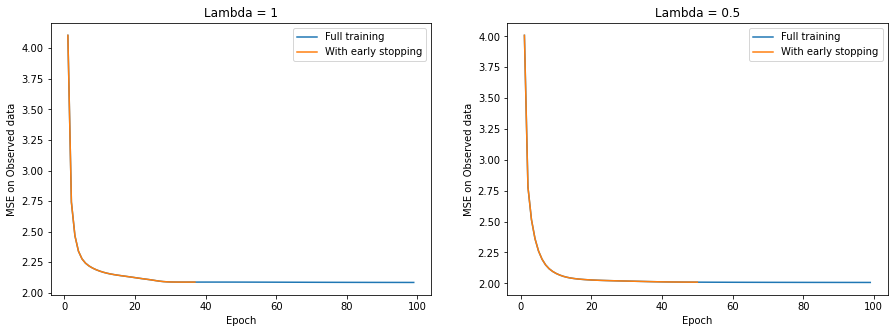

In [75]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (15,5))

x_axis_labels = [i for i in range(1, len(mseo_1)+1)]
shorter_x_axis_labels = [i for i in range(1, len(mseo_early_1)+1)]
ax0.plot(x_axis_labels, mseo_1, label="Full training")
ax0.plot(shorter_x_axis_labels, mseo_early_1, label="With early stopping")
ax0.legend()
ax0.set_xlabel('Epoch')
ax0.set_ylabel('MSE on Observed data')
ax0.set_title('Lambda = 1')

x_axis_labels = [i for i in range(1, len(mseo_0_5)+1)]
shorter_x_axis_labels = [i for i in range(1, len(mseo_early_0_5)+1)]
ax1.plot(x_axis_labels, mseo_0_5, label="Full training")
ax1.plot(shorter_x_axis_labels, mseo_early_0_5, label="With early stopping")
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE on Observed data')
ax1.set_title('Lambda = 0.5')

Text(0.5, 1.0, 'Lambda = 0.0001 (Early stopping was not triggered)')

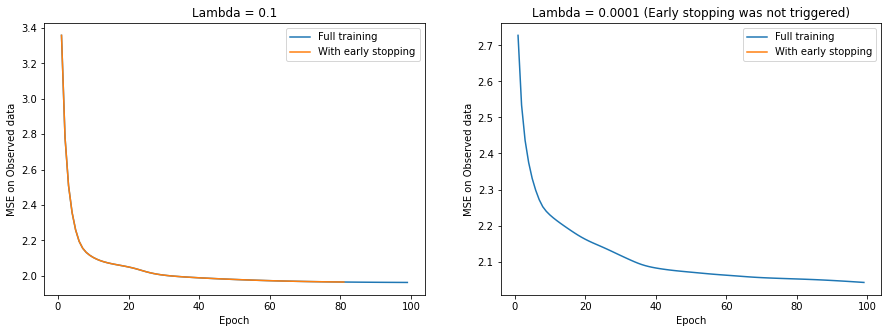

In [78]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (15,5))

x_axis_labels = [i for i in range(1, len(mseo_0_1)+1)]
shorter_x_axis_labels = [i for i in range(1, len(mseo_early_0_1)+1)]
ax0.plot(x_axis_labels, mseo_0_1, label="Full training")
ax0.plot(shorter_x_axis_labels, mseo_early_0_1, label="With early stopping")
ax0.legend()
ax0.set_xlabel('Epoch')
ax0.set_ylabel('MSE on Observed data')
ax0.set_title('Lambda = 0.1')

x_axis_labels = [i for i in range(1, len(mseo_0_0001)+1)]
shorter_x_axis_labels = [i for i in range(1, len(mseo_early_0_0001)+1)]
ax1.plot(x_axis_labels, mseo_0_0001, label="Full training")
ax1.plot(shorter_x_axis_labels, mseo_early_0_0001, label="With early stopping")
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE on Observed data')
ax1.set_title('Lambda = 0.0001 (Early stopping was not triggered)')

The obtained final MSEO values also appear to be quite close. It appears that the difference here is small, and which option one might prefer effectively depends on the random initialisation of both settings.